In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# QUESTO INSTALL xlrd, openpyxl all'interno del virtualenv
# FONDAMENTALE!!!!
#

import sys
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install openpyxl


mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import os

WORKDIR = "csv/"
EXT = '.csv'
VOL_AVG_PERIOD = 20

### Importo la lista degli ETF e ETC borsaitalia

In [364]:
dfEtfInfo = pd.read_excel('infoproviders.xlsx').iloc[6:,:]
dfEtfInfo.columns = dfEtfInfo.iloc[0,:].tolist()
dfEtfInfo = dfEtfInfo.iloc[1:,:]
dfEtfInfo.set_index('N.',inplace=True)
# df2['Strumento'].unique()
# df2.drop(df2[df2['Strumento'] == 0].index, inplace=True) # pulisce
dfEtfInfo = dfEtfInfo[dfEtfInfo['Strumento'] == 'ETF']
dfEtfInfo = dfEtfInfo[['ISIN','Nome','Reuters RIC (Italy)','Indice Benchmark','TER','Area Benchmark','Emittente','Strumento']]
dfEtfInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente','strumento']
# df2.set_index('ticker', inplace=True)

In [365]:
dfEtcInfo = pd.read_excel('infoprovider_etc.xlsx').iloc[6:,:]
dfEtcInfo.columns = dfEtcInfo.iloc[0,:].tolist()
dfEtcInfo = dfEtcInfo.iloc[1:,:]
dfEtcInfo.set_index('N.',inplace=True)
dfEtcInfo = dfEtcInfo[['ISIN','Nome','Reuters RIC (Italy)','Indice Benchmark','TER','Area Benchmark','Emittente','Strumento']]
dfEtcInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente','strumento']

In [366]:
df = pd.concat([dfEtfInfo, dfEtcInfo], ignore_index=True)

In [367]:
# capisce se è da usare il file ticker o l'isin come sorgente dei dati

def set_data_source(isin, ticker):
    isin_file = WORKDIR + isin + EXT
    if os.path.exists(isin_file):
        return isin
    else:
        ticker_file = WORKDIR + ticker + EXT
        if os.path.exists(ticker_file):
            return ticker
        else:
            return None
    
df['dataSource'] = df.apply(lambda x: set_data_source(x['isin'],x['ticker']), axis=1)    

In [368]:
df.dropna(inplace=True)  # droppa i ticker per cui non c'è nè il ISIN.csv, nè il TICKER.csv

In [292]:
## SALVO i df

df.to_excel('etf_info.xlsx')
df.to_csv('etf_info.csv')


### Aggiungo 3 colonne con le date di inizio e fine delle quotazioni  e volAvg, disponibili sui file csv

In [293]:
df1 = df.copy()

In [294]:
def get_dates_volume(row):
    
    source = row['dataSource']  # isin o ticker
    try:
        ticker_file = WORKDIR + source + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        volAvg = df.volume.rolling(VOL_AVG_PERIOD).mean()[-1]
    except e:
        end = None
        start = None
        volAvg = None

    return pd.Series([start,end,volAvg])

## LONG!!!
df1[['startDate', 'endDate', 'volAvg']] = df1.apply(get_dates_volume, axis=1)


In [295]:
df1['endDate'] =  pd.to_datetime(df1['endDate'])
df1['startDate'] =  pd.to_datetime(df1['startDate'])
df1 = df1.round({'volAvg':0})

In [296]:
## SALVO i df con volumi e ticker puliti

df1.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.xlsx')
df1.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.csv')



### elimina i ticker con end_date vecchia e quelli con volume NaN (che vuol dire che non esistono file per quel ticker)

In [349]:
df2 = df1.copy()

mask = (df2.endDate < '2019')
df2.drop(df2[mask].index, inplace=True)

df2 = df2[df2.volAvg >= 0]

df2.volAvg = df2.volAvg.astype(int)
df2.ter = df2.ter.astype(float)

In [350]:
## SALVO i df con volumi e ticker puliti

df2.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.xlsx')
df2.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.csv')

## CARICA il DF (reinizializza)

In [360]:
df11 = pd.read_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.csv')
df11['endDate'] =  pd.to_datetime(df11['endDate'])
df11['startDate'] =  pd.to_datetime(df11['startDate'])
df11.drop(df11.columns[0] ,axis=1, inplace=True)
df11.head()

In [363]:
df10 = pd.read_csv('etf_info' + '.csv')
df10.drop(df10.columns[0] ,axis=1, inplace=True)
df10.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource
0,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.00200,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,ETF,LU0136242590
1,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI
2,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI
3,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI
4,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI


In [369]:
df12 = pd.read_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.csv')
df12['endDate'] =  pd.to_datetime(df12['endDate'])
df12['startDate'] =  pd.to_datetime(df12['startDate'])
df12.drop(df12.columns[0] ,axis=1, inplace=True)
df12.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
0,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.00200,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,ETF,LU0136242590,2013-01-14,2019-04-04,685
1,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI,2010-09-09,2019-04-04,12832
2,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI,2012-03-02,2019-04-04,115
3,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI,2012-03-02,2019-04-04,9152
4,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI,2012-03-02,2019-04-04,0


# Analisi dati ETF

In [370]:
df2.describe()

,ter,volAvg
count,970.000000,9.700000e+02
mean,0.004790,8.204153e+04
std,0.003246,1.131141e+06
min,0.000400,0.000000e+00
25%,0.002300,2.692500e+02
50%,0.004000,1.652000e+03
75%,0.006500,7.102000e+03
max,0.018300,2.388080e+07


In [373]:
df2.volAvg.quantile(q=0.85)

16665.34999999999

In [ ]:
# salva i nomi delle aree benchmark in un file
with open('area.csv', "w") as outfile:
    for entries in df.areaBenchmark.unique():
        outfile.write(entries)
        outfile.write("\n")

In [381]:
# costruita a mano dal file area.csv

listaAree = ['AZIONARIO EUROPA - AREA',
'AZIONARIO MONDO',
'AZIONARIO NORD AMERICA',
'COMMODITIES',
'METALLI PREZIOSI',
'REAL ESTATE',
'TITOLI DI STATO - EURO',
'TITOLI DI STATO - MONDO',
'TITOLI DI STATO - NON EURO']

df3 = df2[df2.areaBenchmark.isin(listaAree)]

In [401]:
# salva il df3, con solo i ticker interessanti
df3.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean_mach1.xlsx')
df3.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean_mach1.csv')

In [417]:
# lista 1 ticker 'buoni', costruita a mano

lista1 = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm']
ticker1 = [(x.upper() + '.MI') for x in lista1]

In [423]:
df4 = df2[df2.ticker.isin(ticker1)]

In [424]:
df4

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
85,LU1681042609,AMUNDI MSCI EUROPE UCITS ETF - EUR,CEU.MI,MSCI TRN EUROPE INDEX,0.0015,AZIONARIO EUROPA - AREA,AMUNDI,ETF,CEU.MI,2010-03-17,2019-04-04,1125
134,IE00B5BMR087,ISHARES CORE S&P 500 UCITS ETF USD ACC,CSSPX.MI,S&P 500 TRN USD,0.0007,AZIONARIO NORD AMERICA,ISHARES,ETF,IE00B5BMR087,2010-05-26,2019-04-04,35724
372,IE00B1FZS806,ISHARES EU GOVT 7-10YR UCITS ETF DIST,IBGM.MI,BARCLAYS EURO GOV BOND 10 YEAR TERM,0.0020,TITOLI DI STATO - EURO,ISHARES,ETF,IBGM.MI,2007-03-20,2019-04-04,8904
377,IE00B1FZS798,ISHARES $ TREASURY 7-10YR UCITS ETF DIST,IBTM.MI,BARCLAYS US TREASURY 10 YEAR TERM,0.0020,TITOLI DI STATO - NON EURO,ISHARES,ETF,IBTM.MI,2007-03-20,2019-04-04,10783
407,IE00B1YZSC51,ISHARESCOREMSCIEUROPE UCITS ETF,IMEU.MI,MSCI EUROPE,0.0012,AZIONARIO EUROPA - AREA,ISHARES,ETF,IMEU.MI,2008-03-18,2019-04-04,157330
444,IE0031442068,ISHARESCORES&P500$(DIST) UCITS ETF,IUSA.MI,S&P 500,0.0007,AZIONARIO NORD AMERICA,ISHARES,ETF,IUSA.MI,2004-05-11,2019-04-04,246870
596,IE00B4K48X80,ISHARESCOREMSCIEUROPE€(ACC) UCITS ETF,SMEA.MI,MSCI TRN EUROPE INDEX,0.0012,AZIONARIO EUROPA - AREA,ISHARES,ETF,SMEA.MI,2010-02-11,2019-04-04,35167
1144,JE00B1VS3770,ETFS PHYSICAL GOLD,PHAU.MI,1/10 ONCIA TROY DI ORO,0.0039,METALLI PREZIOSI,ETFS SECURITIES,ETC,PHAU.MI,2007-06-20,2019-04-04,25317


In [429]:
ceu = pd.read_csv('csv/CEU.MI.csv', usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
imeu = pd.read_csv('csv/IMEU.MI.csv', usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)

In [439]:

tmp1 = ceu.join(imeu, how='outer', rsuffix='_1')[['close','close_1']]
tmp1.columns=['ceu','imeu']
tmp1


,ceu,imeu
dateTime,,
2008-03-18,NaN,18.700
2008-03-19,NaN,18.700
2008-03-20,NaN,18.700
2008-03-25,NaN,18.700
2008-03-26,NaN,18.700
2008-03-27,NaN,18.700
2008-03-28,NaN,18.700
2008-03-31,NaN,18.700
2008-04-01,NaN,18.700


In [421]:
df5 = pd.DataFrame()

for index,row in df4.iterrows():
    ticker = row.ticker
    source = row.dataSource
    filename = WORKDIR + source + EXT
    tmpdf = pd.read_csv(filename, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
    df5[ticker] = tmpdf.close


In [428]:
df5.head(30)

,CEU.MI,CSSPX.MI,IBGM.MI,IBTM.MI,IMEU.MI,IUSA.MI,SMEA.MI,PHAU.MI
dateTime,,,,,,,,
2010-03-17,117.91,NaN,157.88,122.93,16.660,8.4575,NaN,80.89
2010-03-18,119.09,NaN,157.82,124.29,16.650,8.5150,27.36,81.92
2010-03-22,118.05,NaN,158.26,125.38,16.475,8.5675,27.27,80.32
2010-03-31,119.55,NaN,158.05,123.77,16.760,8.6425,NaN,81.39
2010-04-08,121.94,NaN,158.35,125.41,17.010,8.8100,NaN,85.20
2010-04-13,121.87,NaN,157.86,123.47,17.180,8.7625,NaN,83.69
2010-04-15,124.06,NaN,157.90,123.68,17.355,8.9125,NaN,84.45
2010-04-16,123.49,NaN,158.43,124.24,17.345,8.8175,NaN,84.10
2010-04-26,122.38,NaN,158.85,126.02,17.200,9.1150,NaN,85.60


# TESTs

In [55]:
z.loc[mask,'end_date'] = z[mask].apply(lambda x: correct_end_date(x['ticker'],x['isin']), axis=1)

In [57]:
z[mask]

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,start_date,end_date,vol_avg
N.,,,,,,,,,,
557,LU1437024992,AMUNDI MSCI BRAZIL UCITS ETF,BRZ.MI,MSCI BRAZIL INDEX,0.0055,AZIONARIO EMERGENTI - CENTRO/SUD AMERICA,AMUNDI,2010-04-19,2019-04-04,12135.0
173,IE00B52SF786,ISHARES MSCI CANADA UCITS ETF USD ACC,CSCA.MI,MSCI CANADA TRN,0.0048,AZIONARIO NORD AMERICA,ISHARES,2010-03-17,2016-01-14,2702.0
220,IE00B5L8K969,ISHARES MSCI EM ASIA UCITS ETF USD ACC,CSEMAS.MI,MSCI EM ASIA TRN INDEX,0.0065,AZIONARIO EMERGENTI - ASIA,ISHARES,2010-09-17,2016-01-12,5152.0
170,IE00B53QG562,ISHARESCOREMSCIEMU(ACC) UCITS ETF,CSEMU.MI,MSCI EMU TRN,0.0012,AZIONARIO EUROPA - AREA,ISHARES,2010-03-11,2016-01-14,1784.0
169,IE00B53QDK08,ISHARESMSCIJAPAN UCITS ETF,CSJP.MI,MSCI TRN JAPAN INDEX,0.0048,AZIONARIO PACIFICO,ISHARES,2010-03-16,2016-01-14,2532.0
165,IE00B53L4X51,ISHARES FTSE MIB UCITS ETF EUR ACC,CSMIB.MI,FTSE MIB TR,0.0033,AZIONARIO ITALIA,ISHARES,2010-03-12,2016-01-14,3555.0
171,IE00B53SZB19,ISHARES NASDAQ 100 UCITS ETF USD ACC,CSNDX.MI,NASDAQ 100,0.0033,AZIONARIO NORD AMERICA,ISHARES,2010-03-16,2016-01-14,1465.0
167,IE00B52MJY50,ISHARES CORE MSCI PAC EX-J UCITS ETF ACC,CSPXJ.MI,MSCI PACIFIC EX JAPAN TRN INDEX,0.0020,AZIONARIO PACIFICO,ISHARES,2010-03-16,2019-04-04,2911.0
217,IE00B5V87390,ISHARES MSCI RUSS ADR/GDR UCITS ETF ACC,CSRU.MI,MSCI RUSSIA ADR/GDR NET USD,0.0065,AZIONARIO EMERGENTI - EST EUROPA,ISHARES,2010-09-22,2016-01-14,2377.0


In [25]:
def myfunc(ticker, isin):
    return str(ticker)+str(isin)

z.loc[mask,'end_date'] = z.apply(lambda x: myfunc(x['isin'],x['ticker']), axis=1)

### Test lettura quotazioni ETF da ./csv/

In [44]:
tickers = ['A500.MI']

In [45]:
ticker_file = WORKDIR + tickers[0] + EXT

#df = pd.read_csv(ticker_file, index_col=1, parse_dates=True)
df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)

In [46]:
df.head()

,open,high,low,close,volume
dateTime,,,,,
2010-09-09,13.645,13.645,13.645,13.645,4750
2010-09-13,13.710,13.725,13.710,13.725,4790
2010-09-14,13.670,13.680,13.595,13.595,60850
2010-09-20,13.630,13.645,13.630,13.645,5850
2010-09-21,13.645,13.650,13.640,13.650,69846


In [ ]:
end = df.index[df.shape[0]-1]
start = df.index[0]

end - start
end.date()

In [ ]:
np.busday_count( start.date(), end.date() )

### correzioni

In [107]:
tickers = ['EUE.MI']

In [125]:
ticker_file = WORKDIR + tickers[0] + EXT

#df = pd.read_csv(ticker_file, index_col=1, parse_dates=True)
df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)

In [127]:
df.loc['2018-11-21','high'] = 31.98
df.loc['2018-11-21','low'] = 31.69
df.loc['2018-11-21','close'] = 31.96



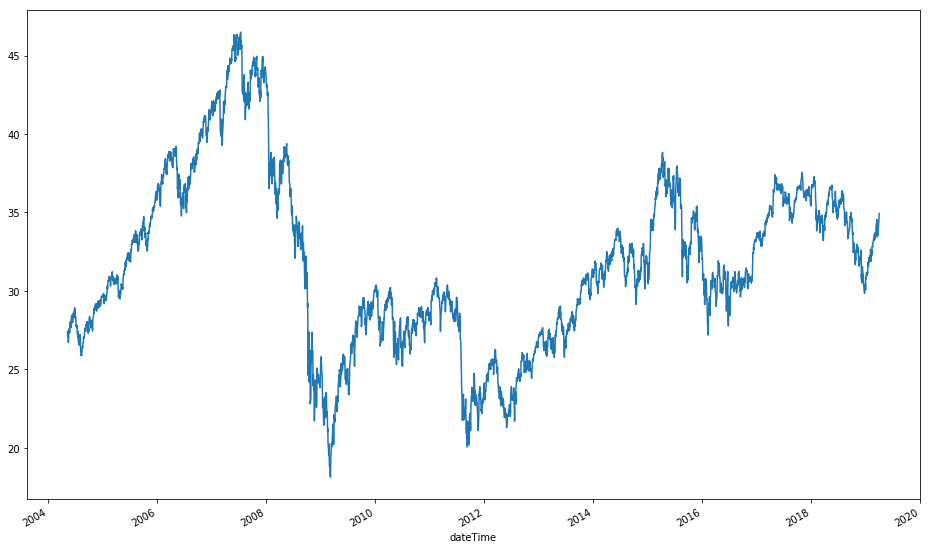

In [133]:
df.close.plot(figsize=(16, 10))

### apply colonne multiple

In [6]:
df100 = dfEtfInfo

In [7]:
def myfunc(isin, ticker):
    return str(isin)+str(ticker)

df100['newcolumn'] = df100.apply(lambda x: myfunc(x['isin'],x['ticker']), axis=1)

In [8]:
df100.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,newcolumn
N.,,,,,,,,
283,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.002,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,LU0136242590100EUA.MI
711,LU1681049109,AMUNDI S&P 500 DAILY HEDGED UCITS ETF,500H.MI,S&P 500 DAILY EURO HEDGED TRN,0.0028,AZIONARIO NORD AMERICA,AMUNDI,LU1681049109500H.MI
710,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.0015,AZIONARIO NORD AMERICA,AMUNDI,LU1681048804A500.MI
707,LU1681046428,AMUNDI GOV HR EMTS IG 1-3 UCITS ETF EUR,AA13.MI,FTSE MTS HIGHEST-RATED EUROZONE GOV BOND 1-3Y,0.0014,TITOLI DI STATO - EURO,AMUNDI,LU1681046428AA13.MI
836,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,LU1829219556AAA13.MI


### leggi ticker.mi csv altrimenti isin.csv

In [27]:
def get_start_date(isin, ticker):
    try:
        ticker_file = WORKDIR + ticker + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        return start
    except FileNotFoundError:
        try:
            ticker_file = WORKDIR + isin + EXT
            df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
            end = df.index[df.shape[0]-1]
            start = df.index[0]
            return start
        except FileNotFoundError:
            return None

def get_end_date(isin, ticker):
    try:
        ticker_file = WORKDIR + ticker + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        return end
    except FileNotFoundError:
        try:
            ticker_file = WORKDIR + isin + EXT
            df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
            end = df.index[df.shape[0]-1]
            start = df.index[0]
            return end
        except FileNotFoundError:
            return None

In [ ]:
df100 = dfEtfInfo[dfEtfInfo.areaBenchmark == 'AZIONARIO NORD AMERICA']

df101 = df3[df3.benchmark == 'S&P 500 TRN USD']

df101['start_date'] = df101.apply(lambda x: get_start_date(x['isin'],x['ticker']), axis=1)
df101['end_date'] = df101.apply(lambda x: get_end_date(x['isin'],x['ticker']), axis=1)

In [ ]:
df101.head()

### Lista le aree degli ETF

In [ ]:
aree = pd.DataFrame(dfEtfInfo.areaBenchmark.unique(),columns=['areaBenchmark'])
aree.sort_values(by='areaBenchmark',inplace=True)

aree

In [32]:
df3 = dfEtfInfo[dfEtfInfo.areaBenchmark == 'AZIONARIO NORD AMERICA']

In [ ]:
df3[df3.benchmark == 'S&P 500 TRN USD']

In [ ]:
df4 = df3[df3.benchmark == 'S&P 500 TRN USD']
# df5 = df4.assign(startDate=df4.ticker.apply(get_start_date),endDate=df4.ticker.apply(get_end_date))

In [ ]:
df4['startDate'] = df4.ticker.apply(get_start_date)
df4['endDate'] = df4.ticker.apply(get_end_date)
    
    

In [111]:
def myfunc100(row):
    return pd.Series(['PIP','PO'])


dfEtfInfo[['test1', 'test2']] = dfEtfInfo.apply(myfunc100, axis=1)

In [ ]:
dfEtfInfo = pd.read_excel('infoprovider_etc.xlsx').iloc[6:,:]
dfEtfInfo.columns = dfEtfInfo.iloc[0,:].tolist()
dfEtfInfo = dfEtfInfo.iloc[1:,:]
dfEtfInfo.set_index('N.',inplace=True)
# df2['Strumento'].unique()
# df2.drop(df2[df2['Strumento'] == 0].index, inplace=True) # pulisce
dfEtfInfo = dfEtfInfo[dfEtfInfo['Strumento'] == 'ETF']
dfEtfInfo = dfEtfInfo[['ISIN','Nome','Reuters RIC (Italy)','Indice Benchmark','TER','Area Benchmark','Emittente']]
dfEtfInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente']
# df2.set_index('ticker', inplace=True)

In [244]:
dfEtcInfo

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente
N.,,,,,,,
1,GB00B15KXP72,ETFS COFFEE,COFF.MI,DOW JONES-UBS COFFEE SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
2,GB00B15KXS04,ETFS CORN,CORN.MI,DOW JONES-UBS CORN SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
3,GB00B15KXT11,ETFS COTTON,COTN.MI,DOW JONES-UBS COTTON SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
4,GB00B15KY435,ETFS SOYBEAN OIL,SOYO.IM,DOW JONES-UBS SOYBEAN OIL SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
5,GB00B15KY542,ETFS SOYBEANS,SOYB.MI,DOW JONES-UBS SOYBEAN SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
6,GB00B15KY658,ETFS SUGAR,SUGA.MI,DOW JONES-UBS SUGAR SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
7,GB00B15KY765,ETFS WHEAT,WEAT.MI,DOW JONES-UBS WHEAT SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
8,JE00B2QXZK10,ETFS COCOA,COCO.MI,DOW JONES-UBS COCOA SUBINDEX,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
9,JE00B78NNK09,ETFS EUR DAILY HEDGED WHEAT,EWAT.MI,DOW JONES-UBS WHEAT SUBINDEX EURO HEDGED DAILY ER,0.0054,PRODOTTI AGRICOLI,ETFS SECURITIES
